# Synthetic data. Previous study.

Main branch => https://github.com/albertovpd/viu_tfm-deep_vision_classification/tree/synthetic_data_study

With a confusion matrix and a classification report we're able to see the weaknesses of our models regarding the classes. Nevertheless, how do you check what images are particulary hard to classify correctly?

This notebook answers that question. In previous branches of the project:
- 150pics of each classes were taken to create the test set.
- the rest:
  - were shuffled and divided into train set (80%), validation set (20%). This process were repeated 5 times, to create 5 subfolders with different configurations of train and validation set => https://github.com/albertovpd/viu_tfm-deep_vision_classification/tree/kfolds_validation

  - the same model was trained with and validated with this 5 subfolders, saving a different configuration each time.

Now I'm going to check in all folders, what pictures are missclassified by all models. Those will be *the hardest pictures to classify*, and I'll work on create synthetic data for those ones.





In [1]:
# Google Drive stuff
#CABESA => https://stackoverflow.com/questions/69315080/is-it-possible-to-get-image-name-from-image-dataset-from-directory


from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Mar 19 16:58:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# tf
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


- libs

In [3]:
%tensorflow_version 2.x
# batch ingestion of pics without pickle
from tensorflow.keras.preprocessing import image_dataset_from_directory

# nns
from tensorflow.keras.applications import ResNet50 

from tensorflow.keras import Model
from tensorflow.keras.models import load_model # Sequential
from tensorflow.keras import layers 

# optimization
from tensorflow.keras.optimizers import SGD #Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping

# nn architectures, metrics, viz & reports => written in my_functions202202 file
import sys
sys.path.append("/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/src")
from missclassification_functions import inferences_target_list, get_missclassified, get_list_of_files

import numpy as np
%matplotlib inline

# navigating through folders
import os

- paths

In [75]:
base_folder = "/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/"
test_folder = base_folder+"input/dataset_1test_5trainval_folders/test_ds/"

reg_input = base_folder+"input/dataset_1test_5trainval_folders/train_val_ds/trainval_regular_partitions/"
missclassified_folder = base_folder+"input/dataset_1test_5trainval_folders/missclassifications/"
missclassified_folder

'/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_1test_5trainval_folders/missclassifications/'

In [7]:
output_folder

'/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision//output/'

- functions

In [58]:
def inferences_target_list(model, data):
    '''
    returns 2 lists: inferences list, real labels
    '''
    # over train set fold1
    y_pred_float = model.predict(data)
    y_pred = np.argmax(y_pred_float, axis=1)

    # get real labels
    y_target = tf.concat([y for x, y in data], axis=0) 
    y_target
    print("lenght inferences and real labels: ", len(y_pred), len(y_target))
    return y_pred, y_target


def get_missclassified(y_pred, y_target):
  '''
  returns a list with the indexes of real labels that were missclassified
  '''
  missclassified = []
  for i, (pred, target) in enumerate(zip(y_pred, y_target.numpy().tolist())):
    if pred!=target:
      #print(i, pred, target)
      missclassified.append(i)
  print("total missclassified: ",len(missclassified))
  return missclassified

def get_list_of_files(dirName):
    '''
    create a list of file and sub directories names in the given directory
    found here => https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/
    ''' 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + get_list_of_files(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

- common parameters

In [9]:
image_size = (128,128)
batch_size = 128
epochs = 250
opt = SGD(momentum=0.9) 

- models!

In [12]:
# available models
onlyfiles = [f for f in os.listdir(output_folder) if (os.path.isfile(os.path.join(output_folder, f)) & (".h5" in f) )]

for files in sorted(onlyfiles):
  print(files)

resnet50_NOdataAug_NOdropout.h5
resnet50_NOdataAug_dropoutFirst007.h5
resnet50_NOdataAug_dropoutFirst007_regKfolds_fold0.h5
resnet50_NOdataAug_dropoutFirst007_regKfolds_fold1.h5
resnet50_NOdataAug_dropoutFirst007_regKfolds_fold2.h5
resnet50_NOdataAug_dropoutFirst007_regKfolds_fold3.h5
resnet50_NOdataAug_dropoutFirst007_regKfolds_fold4.h5
resnet50_NOdataAug_dropoutFirst02.h5
resnet50_NOdataAug_dropoutMid02.h5
resnet50_dataAug_NOdropout.h5
resnet50_dataAug_dropoutFirst02.h5
resnet50_dataAug_dropoutMid02.h5
vgg19_NOdataAug_NOdropout_gelu.h5
vgg19_NOdataAug_dropoutFirst02.h5
vgg19_dataAug_dropoutFirst02.h5
vgg19_dataAug_dropoutFirst02_gelu.h5


In [13]:
# build a dict with the models I want
models_dict = {"resnet50_NOdataAug_dropoutFirst007_regKfolds_fold0.h5": load_model(output_folder+"resnet50_NOdataAug_dropoutFirst007_regKfolds_fold0.h5"),
               "resnet50_NOdataAug_dropoutFirst007_regKfolds_fold1.h5": load_model(output_folder+"resnet50_NOdataAug_dropoutFirst007_regKfolds_fold1.h5"),
               "resnet50_NOdataAug_dropoutFirst007_regKfolds_fold2.h5": load_model(output_folder+"resnet50_NOdataAug_dropoutFirst007_regKfolds_fold2.h5"),
               "resnet50_NOdataAug_dropoutFirst007_regKfolds_fold3.h5": load_model(output_folder+"resnet50_NOdataAug_dropoutFirst007_regKfolds_fold3.h5"),
               "resnet50_NOdataAug_dropoutFirst007_regKfolds_fold4.h5": load_model(output_folder+"resnet50_NOdataAug_dropoutFirst007_regKfolds_fold4.h5")
              }

In [59]:
folders = os.listdir(reg_input)[:1]
folders

['fold2']

In [21]:
# # 150 pics of each class unmutable
# print("test_dataset:")
# test_ds = image_dataset_from_directory(
#     test_folder,
#       class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
#       seed=None,
#       validation_split=None, 
#       subset=None,
#       image_size= image_size,
#       batch_size= batch_size,
#       color_mode='rgb',
#       shuffle=False 
#   )

missclassified_train_folders=[]

for f in folders:
  print(f)
  for nn in models_dict:
    #print(nn)

    # -- train dataset for each folder
    train_path = reg_input+f+"/"+'train_ds/'
    # print("\n train dataset:", "\n", train_path)
    train_ds = image_dataset_from_directory(
        train_path,
        class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
        seed=None,
        validation_split=None, 
        subset=None,
        image_size= image_size,
        batch_size= batch_size,
        color_mode='rgb',
        shuffle=False 
        )
    
    # list of paths for analysed images
    pic_list = get_list_of_files(train_path)
    
    # inferences and real values
    y_pred, y_target = inferences_target_list(models_dict[nn], train_ds)
    
    # missclassified ones
    missclassified = get_missclassified(y_pred, y_target)
    print("elements missclassified in {} for model {}: ".format(f, nn), len(missclassified))
    missclassified_train_folders.append(missclassified)

    # val_path = reg_input+f+"/"+"val_ds"
    # print("\n val dataset:", "\n", val_path)
    # val_ds = image_dataset_from_directory(
    #   val_path,
    #   class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
    #   seed=None,
    #   validation_split=None, 
    #   subset=None,
    #   image_size= image_size,
    #   batch_size= batch_size,
    #   color_mode='rgb',
    #   shuffle=False 
    # )

    # class_names = train_ds.class_names
    # print(class_names)
#print(missclassified_train_folders)

fold2
Found 3598 files belonging to 5 classes.
lenght inferences and real labels:  3598 3598
total missclassified:  714
elements missclassified in fold2 for model resnet50_NOdataAug_dropoutFirst007_regKfolds_fold0.h5:  714
Found 3598 files belonging to 5 classes.
lenght inferences and real labels:  3598 3598
total missclassified:  692
elements missclassified in fold2 for model resnet50_NOdataAug_dropoutFirst007_regKfolds_fold1.h5:  692
Found 3598 files belonging to 5 classes.
lenght inferences and real labels:  3598 3598
total missclassified:  384
elements missclassified in fold2 for model resnet50_NOdataAug_dropoutFirst007_regKfolds_fold2.h5:  384
Found 3598 files belonging to 5 classes.
lenght inferences and real labels:  3598 3598
total missclassified:  722
elements missclassified in fold2 for model resnet50_NOdataAug_dropoutFirst007_regKfolds_fold3.h5:  722
Found 3598 files belonging to 5 classes.
lenght inferences and real labels:  3598 3598
total missclassified:  271
elements mis

- missclassified pics for model 0,1,2,3,4 in this folder:

In [60]:
# list of 5 lists, 1 by folder
print(len(missclassified_train_folders), "\n", missclassified_train_folders)

5 
 [[8, 19, 22, 25, 28, 30, 31, 32, 35, 38, 50, 61, 68, 69, 71, 76, 78, 81, 94, 96, 106, 111, 114, 115, 118, 119, 123, 134, 135, 144, 145, 147, 156, 162, 167, 176, 179, 182, 187, 198, 203, 205, 211, 220, 228, 231, 233, 251, 257, 259, 261, 274, 276, 279, 284, 285, 286, 287, 290, 291, 300, 309, 310, 324, 327, 330, 335, 339, 365, 366, 368, 373, 379, 381, 385, 386, 388, 390, 392, 397, 417, 419, 428, 432, 433, 434, 437, 457, 464, 473, 477, 491, 495, 497, 510, 515, 516, 518, 519, 522, 523, 530, 533, 543, 553, 555, 564, 569, 572, 577, 582, 587, 596, 611, 612, 620, 627, 629, 631, 649, 650, 651, 655, 675, 680, 682, 686, 690, 691, 692, 701, 704, 706, 714, 718, 719, 733, 735, 742, 749, 751, 754, 756, 765, 770, 775, 776, 781, 784, 797, 798, 800, 801, 809, 818, 820, 829, 851, 852, 853, 856, 865, 872, 876, 878, 879, 881, 883, 884, 889, 892, 893, 899, 903, 905, 909, 915, 917, 922, 927, 933, 937, 938, 942, 948, 950, 951, 952, 963, 981, 982, 983, 986, 997, 1004, 1007, 1016, 1021, 1031, 1033, 1034, 103

In [26]:
# it corresponds with the prints above. great.
for arr in missclassified_train_folders:
  print(len(arr))

714
692
384
722
271


In [35]:
# all paths are saved
print(len(pic_list))

3598


- common missclassificated pictures: from the 5 lists above, let's take the elements that always are missclassified

In [65]:
common_missclassified = list(set.intersection(*map(set, missclassified_train_folders)))
# this are the indexes of that images
print(len(common_missclassified), "\n", common_missclassified)

167 
 [2563, 3077, 1031, 1033, 1034, 1552, 1041, 533, 3093, 3102, 1568, 2081, 2597, 1579, 1068, 2604, 2607, 3119, 1077, 1082, 572, 1596, 1599, 1088, 2628, 1611, 2559, 1613, 1619, 2131, 2133, 2646, 3163, 3171, 2148, 620, 627, 2675, 2173, 1151, 2177, 1667, 135, 650, 651, 1163, 2702, 2703, 3217, 3219, 1172, 3237, 682, 3243, 1199, 176, 1714, 3251, 1204, 1718, 1719, 3254, 2747, 2750, 706, 1220, 2244, 1734, 718, 3279, 1232, 1238, 1756, 1252, 742, 1766, 2795, 2798, 751, 3310, 2806, 2296, 2810, 765, 1793, 770, 2306, 2817, 1797, 3329, 2831, 784, 2322, 1299, 1304, 1816, 2842, 2843, 797, 286, 798, 3357, 1314, 2854, 1832, 3370, 3375, 1840, 820, 2871, 1345, 1348, 1860, 1869, 335, 3410, 339, 851, 1878, 2394, 865, 2918, 1895, 1384, 365, 366, 878, 1902, 1906, 1398, 2937, 2427, 1406, 1920, 1411, 388, 1925, 390, 1414, 2439, 905, 1419, 397, 3470, 915, 419, 1967, 3504, 948, 437, 1972, 951, 1977, 3523, 1988, 2001, 2002, 2003, 1492, 3030, 473, 1501, 2535, 2030, 2037, 1527, 3071]


- get images with missclassification

In [71]:
target_missclassified = [y_target[i] for i in common_missclassified]
pred_missclassified = [y_pred[i] for i in common_missclassified]

# get paths of missclassified pics
pic_list_missclassified = [pic_list[i] for i in common_missclassified]

# indexes of common missclassified elements for all models
print(len(pic_list_missclassified))

167


In [57]:
for i in common_missclassified:
  if y_target[i] == y_pred[i]:
    raise ValueError("dude problem with ordering indexes")
  else:
    print("real class label vs inferred: {}-{} - {} <= idx: {}".format(y_target[i], y_pred[i], pic_list[i][125:], i))

real label vs inferred: 4-3 - regular_partitions/fold2/train_ds/Livingroom/living_473.jpg <= idx: 2563
real label vs inferred: 3-2 - regular_partitions/fold2/train_ds/Kitchen/kitchen_219.jpg <= idx: 3077
real label vs inferred: 0-3 - regular_partitions/fold2/train_ds/Bedroom/bed_212.jpg <= idx: 1031
real label vs inferred: 0-3 - regular_partitions/fold2/train_ds/Bedroom/bed_728.jpg <= idx: 1033
real label vs inferred: 0-3 - regular_partitions/fold2/train_ds/Bedroom/bed_73.jpg <= idx: 1034
real label vs inferred: 2-3 - regular_partitions/fold2/train_ds/Bedroom/bed_436.jpg <= idx: 1552
real label vs inferred: 0-2 - regular_partitions/fold2/train_ds/Bedroom/bed_1350.jpg <= idx: 1041
real label vs inferred: 0-1 - regular_partitions/fold2/train_ds/Dinning/din_904.jpg <= idx: 533
real label vs inferred: 3-4 - regular_partitions/fold2/train_ds/Kitchen/kitchen_1200.jpg <= idx: 3093
real label vs inferred: 3-0 - regular_partitions/fold2/train_ds/Kitchen/kitchen_1082.jpg <= idx: 3102
real label 

- copy missclassified images to a new folder for its study (maintaining a subfolder for each class)

In [80]:
ME HE QUEDADO AQUÍ CABESA
# create a folder with 5 subfolders, 1 for each class
for cls in class_names:
  print(missclassified_folder)
  os.makedirs(missclassified_folder+ cls, exist_ok=True)

/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_1test_5trainval_folders/missclassifications/
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_1test_5trainval_folders/missclassifications/
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_1test_5trainval_folders/missclassifications/
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_1test_5trainval_folders/missclassifications/
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_1test_5trainval_folders/missclassifications/


In [74]:
for pic in pic_list_missclassified:
  print(pic[125:])

regular_partitions/fold2/train_ds/Livingroom/living_473.jpg
regular_partitions/fold2/train_ds/Kitchen/kitchen_219.jpg
regular_partitions/fold2/train_ds/Bedroom/bed_212.jpg
regular_partitions/fold2/train_ds/Bedroom/bed_728.jpg
regular_partitions/fold2/train_ds/Bedroom/bed_73.jpg
regular_partitions/fold2/train_ds/Bedroom/bed_436.jpg
regular_partitions/fold2/train_ds/Bedroom/bed_1350.jpg
regular_partitions/fold2/train_ds/Dinning/din_904.jpg
regular_partitions/fold2/train_ds/Kitchen/kitchen_1200.jpg
regular_partitions/fold2/train_ds/Kitchen/kitchen_1082.jpg
regular_partitions/fold2/train_ds/Bedroom/bed_650.jpg
regular_partitions/fold2/train_ds/Livingroom/living_282.jpg
regular_partitions/fold2/train_ds/Kitchen/kitchen_174.jpg
regular_partitions/fold2/train_ds/Bedroom/bed_966.jpg
regular_partitions/fold2/train_ds/Bedroom/bed_1387.jpg
regular_partitions/fold2/train_ds/Kitchen/kitchen_276.jpg
regular_partitions/fold2/train_ds/Kitchen/kitchen_101.jpg
regular_partitions/fold2/train_ds/Kitchen/k

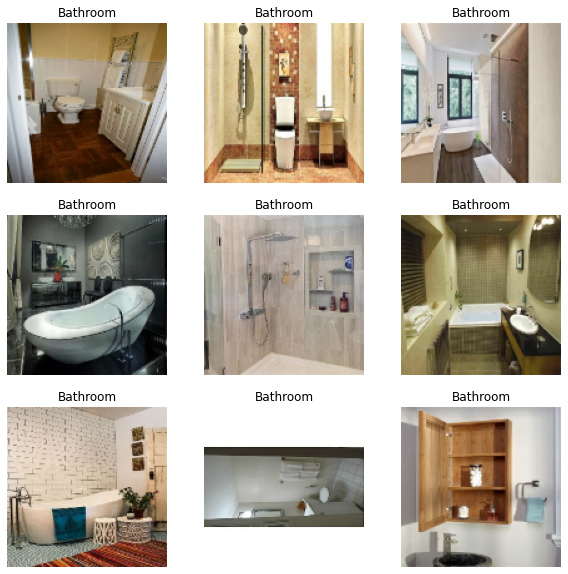

In [77]:
class_names = train_ds.class_names
import matplotlib.pyplot as plt
 
plt.figure(figsize = (10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")